In [2]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

**Instruções gerais:** Sua submissão <u>deve</u> conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynb

Caso você opte por resolver as questões de "papel e caneta" em um editor de $\LaTeX$ externo, o inclua no final da versão pdf do 'ipynb'--- submetendo um <u>único pdf</u>.

# Trabalho de casa 04: Seleção de modelo e hiperparametros

**1.** O código abaixo carrega o banco de dados *California housing*. Divida o banco de dados em treino, teste e validação. Use o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Use a fórmula analítica para estimar os pesos do modelo de regressão. Plote os MSE no conjunto de treino e validação em função de $c$. Comente o resultado. Avalie a performance do modelo ótimo no conjunto de teste e também comente.

In [3]:
SEED = 42
np.random.seed(SEED)

X, y = fetch_california_housing(return_X_y=True)

In [4]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=SEED)
Xtrain, Xval, ytrain, yval = train_test_split(Xtrain, ytrain, test_size=0.2, random_state=SEED)

# adicionamos o bias aos dados de treino, validação e teste
Xtrain = np.hstack((Xtrain, np.ones((Xtrain.shape[0], 1))))
Xval = np.hstack((Xval, np.ones((Xval.shape[0], 1))))
Xtest = np.hstack((Xtest, np.ones((Xtest.shape[0], 1))))

Vamos utilizar o conjunto de validação para escolher o coeficiente de regularização $c$ para um modelo de regressão linear com penalização $L_2$. Para isso, vamos utilizar a fórmula analítica para estimar os pesos do modelo de regressão.

Implementamos uma função que recebe como parâmetros os dados de treino e de validação e retorna o melhor valor de c para o caso de uma regressão linear de forma fechada. A penalização utilizada é a L2, também conhecida como Ridge Regression. Isso altera um pouco o cálculo dos pesos, cuja forma se torna:

$$\text{weights} = (X^T X + cI)^{-1} X^Ty$$

In [5]:
# implementamos uma função que recebe como parâmetros os dados de treino e de 
# validação e retorna o melhor valor de c para o caso de uma regressão linear 
# de forma fechada. A penalização utilizada ṕe

possible_c = [0, 0.01, 0.1, 0.5, 1, 2, 4, 6, 8, 10]

def get_best_c(Xtrain, ytrain, Xval, yval):
    MSEs = []
    
    for c in possible_c:
        # estima os pesos da regressão linear de forma fechada
        weights = np.linalg.inv(Xtrain.T @ Xtrain + c * np.eye(Xtrain.shape[1])) @ Xtrain.T @ ytrain
        
        # obtem a predição para os dados de validação
        ypred = Xval @ weights
       
        # calcula o MSE
        MSE = np.mean((ypred - yval) ** 2)
        MSEs.append(MSE)
    
    best_c = possible_c[np.argmin(MSEs)]
    return best_c, MSEs, possible_c

best_c, MSEs, possible_c = get_best_c(Xtrain, ytrain, Xval, yval)
print(f'Melhor c: {best_c}')

Melhor c: 0


Dados os valores de c possíveis na lista definida na primeira linha do código, observamos que o melhor valor de c é 0 (isto é, quando não o utilizamos). Isso se deve ao fato de que o Mean Squared Error é o menor para esse valor de c.

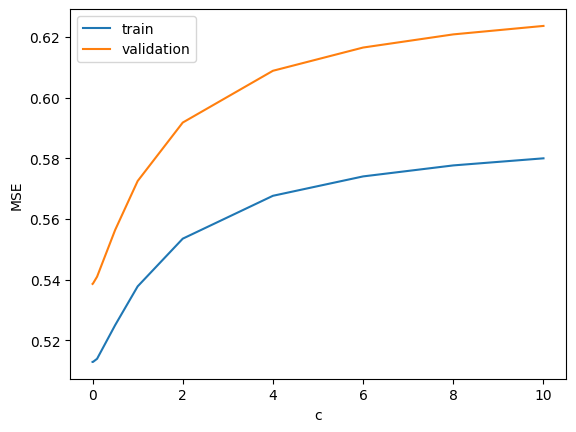

In [6]:
# ajustamos o modelo com os dados de treino e validação 
# utilizando os valores possíveis de c, observando 
# como o MSE se comporta em cada caso
_, MSEs_train, _ = get_best_c(Xtrain, ytrain, Xtrain, ytrain)
_, MSEs_val, _ = get_best_c(Xtrain, ytrain, Xval, yval)

# plot MSEs
import matplotlib.pyplot as plt
plt.plot(possible_c, MSEs_train, label='train')
plt.plot(possible_c, MSEs_val, label='validation')
plt.xlabel('c')
plt.ylabel('MSE')
plt.legend()
plt.show()

De fato, conforme observamos na aplicação da função anterior, o valor de c com menor MSE é 0. Note, inclusive, que conforme aumentamos o valor de c, o MSE aumenta. O aumento no MSE é esperado na medida em que, quando aumentamos o valor de c (e, portanto, da penalização sobre os pesos), reduzimos o valor dos pesos e aumentamos a flexibilidade do modelo, podendo reduzir a capacidade de ajuste aos dados e aumentando MSE.

In [7]:
Xfull = np.vstack((Xtrain, Xval))
yfull = np.hstack((ytrain, yval))

weights = np.linalg.inv(Xfull.T @ Xfull + best_c * np.eye(Xfull.shape[1])) @ Xfull.T @ yfull
ypred = Xtest @ weights
MSE = np.mean((ypred - ytest) ** 2)

print(f'MSE no conjunto de teste: {MSE.round(3)}')

MSE no conjunto de teste: 0.556


**2.** Implemente 5-fold *nested cross validation* para escolher entre os métodos $k$-NN e regressão linear com regularização $L_2$ (similar ao exercício acima). Considere $k \in \{1, 2, 3, 4, 5\}$ e $c \in \{0, 1, 10, 100\}$. Use o mesmo banco de dados do último exercício e comente o resultado. Em média, qual valor de hiperparametro resulta na melhor performance para o método escolhido?

Obs.: para simplificar sua vida, use o $k$-NN para regressão do scikit-learning com distância euclidiana.

In [55]:
possible_c = [0, 1, 10, 100]
possible_k = [1, 2, 3, 4, 5]

Xfull = np.concatenate((Xtrain, Xval), axis=0)
yfull = np.concatenate((ytrain, yval), axis=0)

In [56]:
MSEkNN = []
MSELinear = []

# append len(possible_k) lists to MSEkNN
for item in range(len(possible_k)):
    MSEkNN.append([])

# append len(possible_c) lists to MSELinear
for item in range(len(possible_c)):
    MSELinear.append([])

In [57]:
parametros = {'kNN': possible_k, 'RegressaoLinear': possible_c}
metodos = ['kNN', 'RegressaoLinear']

# implementa uma funcao que determina o melhor modelo (menor MSE no conjunto de validacao)
def melhor_metodo(metodos, Xtrain, Xtest, ytrain, ytest):
    for metodo in metodos:
        if metodo == 'kNN':
            # para cada valor de k, treina o modelo e calcula o MSE no conjunto de validacao
            for i, k in enumerate(possible_k):
                modelo = KNeighborsRegressor(n_neighbors=k)
                modelo.fit(Xtrain, ytrain)
                ypred = modelo.predict(Xtest)
                MSE = np.mean((ypred - ytest) ** 2)
                MSEkNN[i].append(MSE)
        
        elif metodo == 'RegressaoLinear':
            # para cada valor de c, treina o modelo e calcula o MSE no conjunto de validacao
            for i, c in enumerate(possible_c):
                weights = np.linalg.inv(Xtrain.T @ Xtrain + c * np.eye(Xtrain.shape[1])) @ Xtrain.T @ ytrain
                ypred = Xtest @ weights
                MSE = np.mean((ypred - ytest) ** 2)
                MSELinear[i].append(MSE)
            
    return MSEkNN, MSELinear

In [58]:
Xfolds, yfolds = np.array(np.array_split(X, 5)), np.array(np.array_split(y, 5))

for i in range(5):
    # divide os dados de treino e teste
    Xtest = Xfolds[i]
    ytest = yfolds[i]

    Xfull = np.concatenate(Xfolds[np.arange(len(Xfolds)) != i], axis=0)
    yfull = np.concatenate(yfolds[np.arange(len(yfolds)) != i], axis=0)

    # divide os dados de treino em 4 folds
    XfoldsFull, yfoldsFull = np.array(np.array_split(Xfull, 4)), np.array(np.array_split(yfull, 4))

    for j in range(4):

        Xval = XfoldsFull[j]
        yval = yfoldsFull[j]

        Xtrain = np.concatenate(XfoldsFull[np.arange(len(XfoldsFull)) != j], axis=0)
        ytrain = np.concatenate(yfoldsFull[np.arange(len(yfoldsFull)) != j], axis=0)

        # obtem MSEs para cada fold e para cada metodo
        MSEkNN_, MSELinear_ = melhor_metodo(metodos, Xtrain, Xval, ytrain, yval)

# calcula o MSE medio para cada metodo
for i in range(len(possible_k)):
    MSEkNN_[i] = np.mean(MSEkNN_[i])

for i in range(len(possible_c)):
    MSELinear_[i] = np.mean(MSELinear_[i])

In [53]:
# get the best k and c
melhor_k = possible_k[np.argmin(MSEkNN)]
MSEkNN = np.min(MSEkNN)

melhor_c = possible_c[np.argmin(MSELinear)]
MSELinear = np.min(MSELinear)

if MSEkNN < MSELinear:
    print('Melhor modelo: kNN')
    print(f'Melhor k: {melhor_k}')
else:
    print('Melhor modelo: Regressão Linear')
    print(f'Melhor c: {melhor_c}')

Melhor modelo: Regressão Linear
Melhor c: 0


# Exercício de "papel e caneta"

**1.** Nas nota de aula, derivamos o "dilema viés-variância" calculando o MSE esperado entre a função alvo de aprendizado $f$ e a predição do nosso modelo $h_{\mathcal{D}}$:

$$
\mathbb{E}_{x, \mathcal{D}} 
    \left[ 
        \left( 
        h_{\mathcal{D}}(x) - f\left(x\right) 
        \right)^2
    \right] =
\mathbb{E}_{x}[\underbrace{\textrm{Var}_{\mathcal{D}}[
        h_{\mathcal{D}}(x)]}_{\text{ Variância} }] + \mathbb{E}_{x} [ (\underbrace{\mathbb{E}_{\mathcal{D}}[
        h_{\mathcal{D}}(x) - f\left(x\right)]  }_{\text{Viés}})^2].
$$

Com isso em mente, adapte nossa derivação para o caso em que as respostas de teste $f(x)$ são corrompidas por um ruído aditivo aleatório $\epsilon$ com média zero, i.e., observamos $f^\prime(x) = f(x) + \epsilon$. Mais concretamente, trabalhe a seguinte esperança para derivar uma decomposição similar à da nota de aula:
$$
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right)
        \right)^2
    \right] 
$$

Compare a diferença entre a decomposição que você obteve e a da nota de aula.

Dica: sua decomposição deve se diferenciar da acima em apenas um termo aditivo, que envolve uma esperança sobre $x$ e $y$.


### **Resposta**

Vamos adaptar a derivação:

$$
\begin{aligned}
\mathbb{E}_{x, \epsilon, \mathcal{D}} 
    \left[
        \left( 
        h_{\mathcal{D}}(x) - f^\prime\left(x\right)
        \right)^2
    \right] 
    &=
\mathbb{E}_{x, \epsilon, \mathcal{D}}
    \left[
        (h_\mathcal{D}(x))^2 + (f^\prime(x))^2 - 2h_\mathcal{D}(x)f^\prime(x)
    \right]
    \\
    &= \mathbb{E}_{x}[\mathbb{E}_{\mathcal{D}}[(h_\mathcal{D}(x))^2]] + \mathbb{E}_{x, \epsilon}[f^\prime(x)^2 - 2\mathbb{E}_{\mathcal{D}}[h_\mathcal{D}(x)f^\prime(x)]] \\
    &= \mathbb{E}_{x}[\mathbb{E}_{\mathcal{D}}[(h_\mathcal{D}(x))^2]] + \mathbb{E}_{x, \epsilon}[(f(x)+\epsilon)^2 - 2\mathbb{E}_{\mathcal{D}}[h_\mathcal{D}(x)(f(x)+\epsilon)]] \\
    &= \mathbb{E}_{x}[\mathbb{E}_{\mathcal{D}}[(h_\mathcal{D}(x))^2]] + \mathbb{E}_{x, \epsilon}[(f(x))^2 + 2\epsilon f(x) + \epsilon^2 - 2\mathbb{E}_{\mathcal{D}}[h_\mathcal{D}(x)f(x)] - 2\epsilon\mathbb{E}_{\mathcal{D}}[h_\mathcal{D}(x)]] \\
    &= \mathbb{E}_{x}[\mathbb{E}_{\mathcal{D}}[(h_\mathcal{D}(x))^2]] + \mathbb{E}_{x}[f(x)^2 - 2\mathbb{E}_\mathcal{D}[h_\mathcal{D}(x)]f(x) + \mathbb{E}_{\epsilon}[\epsilon^2 + 2f(x)\epsilon-2\mathbb{E}_\mathcal{D}[h(x)]\epsilon]] \\
    &= \mathbb{E}_{x}[\mathbb{E}_{\mathcal{D}}[(h_\mathcal{D}(x))^2]] + \mathbb{E}_{x}[f(x)^2 - 2\mathbb{E}_\mathcal{D}[h_\mathcal{D}(x)]f(x) + \mathbb{E}_{\epsilon}[\epsilon^2]] \\
    &= \mathbb{E}_{x}[\mathbb{E}_{\mathcal{D}}[(h_\mathcal{D}(x))^2]] + \mathbb{E}_{x}[f(x)^2 - 2\mathbb{E}_\mathcal{D}[h_\mathcal{D}(x)]f(x)] + \mathbb{E}_{x, \epsilon}[\epsilon^2] \\
    &= \mathbb{E}_{x}\underbrace{[\textrm{Var}_\mathcal{D}[h_\mathcal{D}(x)]]}_{\text{ Variância }} + \mathbb{E}_{x}\underbrace{[(\mathbb{E}_{\mathcal{D}}[f(x) - h_\mathcal{D}(x)])^2]}_{\text{Viés}} + \mathbb{E}_{x, \epsilon}\underbrace{[\epsilon^2]}_\text{Ruído} 
\end{aligned}
$$

No que diz respeito às diferenças de decomposição, obtivemos um novo termo, o ruído. Em particular, do ponto de vista de manipulações, nos valemos do fato de que o ruído tem média zero e, portanto, alguns valores que eram multiplicados por $\mathbb{E}_{\epsilon}[\epsilon]$ foram cortados. No passo final, realizamos o mesmo procedimento das notas de aula, onde somamos dois termos iguais (que somam zero, naturalmente), $\mathbb{E}_{x, \epsilon}[\mathbb{E}_\mathcal{D}[h_\mathcal{D}(x)]^2]$, para obter a variância e o viés.